In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
#from lr_utils import load_dataset

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
#Load Training Data
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x_orig shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_orig shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x_orig shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x_orig shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


y = [1], it's a 'cat' picture.


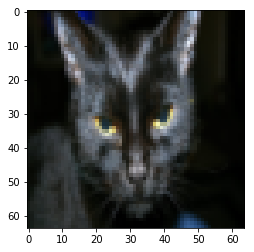

In [4]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [5]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)

#standardize our dataset
#see lab 1 notes for more info
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))
print ("sanity check after reshaping: " + str(train_set_x[0:5,0]))

#Old
#train_set_x shape: (12288, 209)
#test_set_x shape: (12288, 50)

train_set_x shape: (209, 12288)
train_set_y shape: (1, 209)
test_set_x shape: (50, 12288)
test_set_y shape: (1, 50)
sanity check after reshaping: [ 17 196  82   1   9]
sanity check after reshaping: [0.06666667 0.76862745 0.32156863 0.00392157 0.03529412]


In [6]:
#convert numpy arrays to torch tensors
pt_train_set_x = torch.from_numpy(train_set_x).float()
pt_train_set_y = torch.from_numpy(train_set_y).float()
pt_test_set_x = torch.from_numpy(test_set_x).float()
pt_test_set_y = torch.from_numpy(test_set_y).float()


print (train_set_x.shape)
print (pt_train_set_x.shape)
print (train_set_y.shape)
print (pt_train_set_y.shape)
print (pt_train_set_x.type())


(209, 12288)
torch.Size([209, 12288])
(1, 209)
torch.Size([1, 209])
torch.FloatTensor


In [7]:
class Model(torch.nn.Module):

    def __init__(self):
        """
        In the constructor we instantiate nn.Linear module
        """
        super(Model, self).__init__()
        self.l1 = torch.nn.Linear(12288, 6)
        self.l2 = torch.nn.Linear(6, 4)
        self.l3 = torch.nn.Linear(4, 1)

        self.sigmoid = torch.nn.Sigmoid()
        self.ReLU = torch.nn.ReLU()

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        out1 = self.ReLU(self.l1(x))
        out2 = self.ReLU(self.l2(out1))
        y_pred = self.sigmoid(self.l3(out2))
        return y_pred

# our model
model = Model()

In [8]:
# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


In [20]:
# Training loop

#Log some data
costs = []
train_acc = []
test_acc = []

#Train
for epoch in range(1000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(pt_train_set_x)

    # Compute and print loss
    loss = criterion(y_pred, pt_train_set_y)

        
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    # Record Metrics
    if epoch % 10 == 0:
        print(epoch, loss.data[0])
        costs.append(loss.data[0])
        
        #Record Accuracy
        temp_acc_train = accuracy(pt_train_set_x, train_set_y)
        train_acc.append(temp_acc_train)
    
        temp_acc_test = accuracy(pt_test_set_x, test_set_y)
        test_acc.append(temp_acc_test)
        

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1594: UserWarning: Using a target size (torch.Size([1, 209])) that is different to the input size (torch.Size([209, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0 tensor(0.1345)
10 tensor(0.1514)
20 tensor(0.1320)
30 tensor(0.1316)
40 tensor(0.1342)
50 tensor(0.1308)
60 tensor(0.1307)
70 tensor(0.1337)
80 tensor(0.1336)
90 tensor(0.1296)
100 tensor(0.1282)
110 tensor(0.1288)
120 tensor(0.1309)
130 tensor(0.1265)
140 tensor(0.1387)
150 tensor(0.1264)
160 tensor(0.1442)
170 tensor(0.1246)
180 tensor(0.1248)
190 tensor(0.1235)
200 tensor(0.1239)
210 tensor(0.1260)
220 tensor(0.1221)
230 tensor(0.1226)
240 tensor(0.1221)
250 tensor(0.1223)
260 tensor(0.1210)
270 tensor(0.1201)
280 tensor(0.1201)
290 tensor(0.1211)
300 tensor(0.1190)
310 tensor(0.1617)
320 tensor(0.1179)
330 tensor(0.1182)
340 tensor(0.1182)
350 tensor(0.1169)
360 tensor(0.1174)
370 tensor(0.1168)
380 tensor(0.1159)
390 tensor(0.1164)
400 tensor(0.1154)
410 tensor(0.1148)
420 tensor(0.1143)
430 tensor(0.1139)
440 tensor(0.1137)
450 tensor(0.1134)
460 tensor(0.1160)
470 tensor(0.1127)
480 tensor(0.1133)
490 tensor(0.1121)
500 tensor(0.1120)
510 tensor(0.1122)
520 tensor(0.1123)
530 

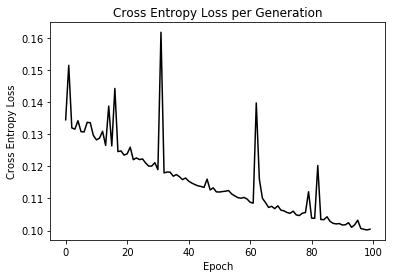

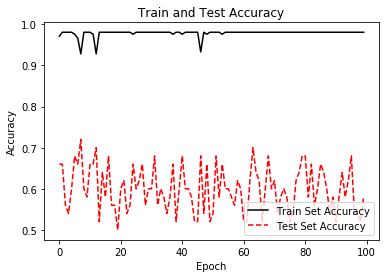

In [21]:
# Plots

# Plot loss over time# Plot  
plt.plot(costs, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
    

In [22]:
# Train and Test Set Predictions
print ("train set accuracy = " + str (accuracy(pt_train_set_x,train_set_y)))
print ("test set accuracy = " + str (accuracy(pt_test_set_x,test_set_y)))


train set accuracy = 0.9808612440191388
test set accuracy = 0.58


In [25]:
print ("pt_train_set_x: " + str (pt_train_set_x.shape))
print (train_set_y.shape)
print (pt_train_set_y.shape)

pt_train_set_x: torch.Size([209, 12288])
(1, 209)
torch.Size([1, 209])


In [11]:
def accuracy(X, Y):
    """
    This function is used to measure accuracy of the model.
    
    Arguments:
    X -- data set of examples you would like to label
    Y -- labels
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    prediction = model(X)
    np_prediction = np.round(prediction.detach().numpy())
    predictions_correct = np.equal(np_prediction, Y.T)
    p = np.mean(predictions_correct)
        
    return p

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


The Algo says tensor([[1.]], grad_fn=<SigmoidBackward>)


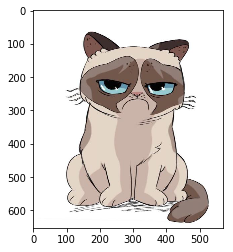

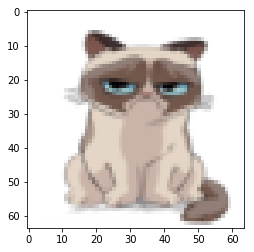

In [134]:
#Test Image 
#fname = "datasets/cat1.JPG"  #LR is good
#fname = "datasets/cat3.JPG"  #LR is bad
#fname = "datasets/cat4.JPG"  #LR is good
fname = "datasets/cartoon_grump.JPG"   #LR is bad
#fname = "datasets/puss.JPG"   #LR is bad
#fname = "datasets/meandog.JPG"  #LR is good
#fname = "datasets/puppy.JPG"  #LR is good
image = np.array(ndimage.imread(fname, flatten=False))
resized_image = scipy.misc.imresize(image, size=(64,64))
my_image = resized_image.reshape((1, 64*64*3))
pt_my_image = torch.from_numpy(my_image).float()


print ("The Algo says " + str(model(pt_my_image)))
plt.imshow(image)
plt.show()
plt.imshow(resized_image)

In [129]:
for param in model.parameters():
  print(param.data)

tensor([[ 3.7092e-03, -2.6056e-02, -1.1001e-02,  ..., -1.6957e-02,
         -3.4043e-02,  3.2790e-02]])
tensor([0.0039])


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
NEXT
1. need to double check shapes on this one